In [ ]:
# Problem 1 (a)
import pandas as pd
Auto = pd.read_csv("Auto.csv", na_values=["?"])

# check the data cleanliness
#print(Auto.info())
#print(Auto.isna().sum())
#print(Auto.head())

mpg_median = Auto["mpg"].median()
print(mpg_median) 

Auto["mpg01"] = (Auto["mpg"] > mpg_median).astype(int)
print(Auto["mpg01"].value_counts())
print(Auto[["mpg", "mpg01"]].head(10))

22.75
mpg01
0    196
1    196
Name: count, dtype: int64
    mpg  mpg01
0  18.0      0
1  15.0      0
2  18.0      0
3  16.0      0
4  17.0      0
5  15.0      0
6  14.0      0
7  14.0      0
8  14.0      0
9  15.0      0


Note: you may need to restart the kernel to use updated packages.


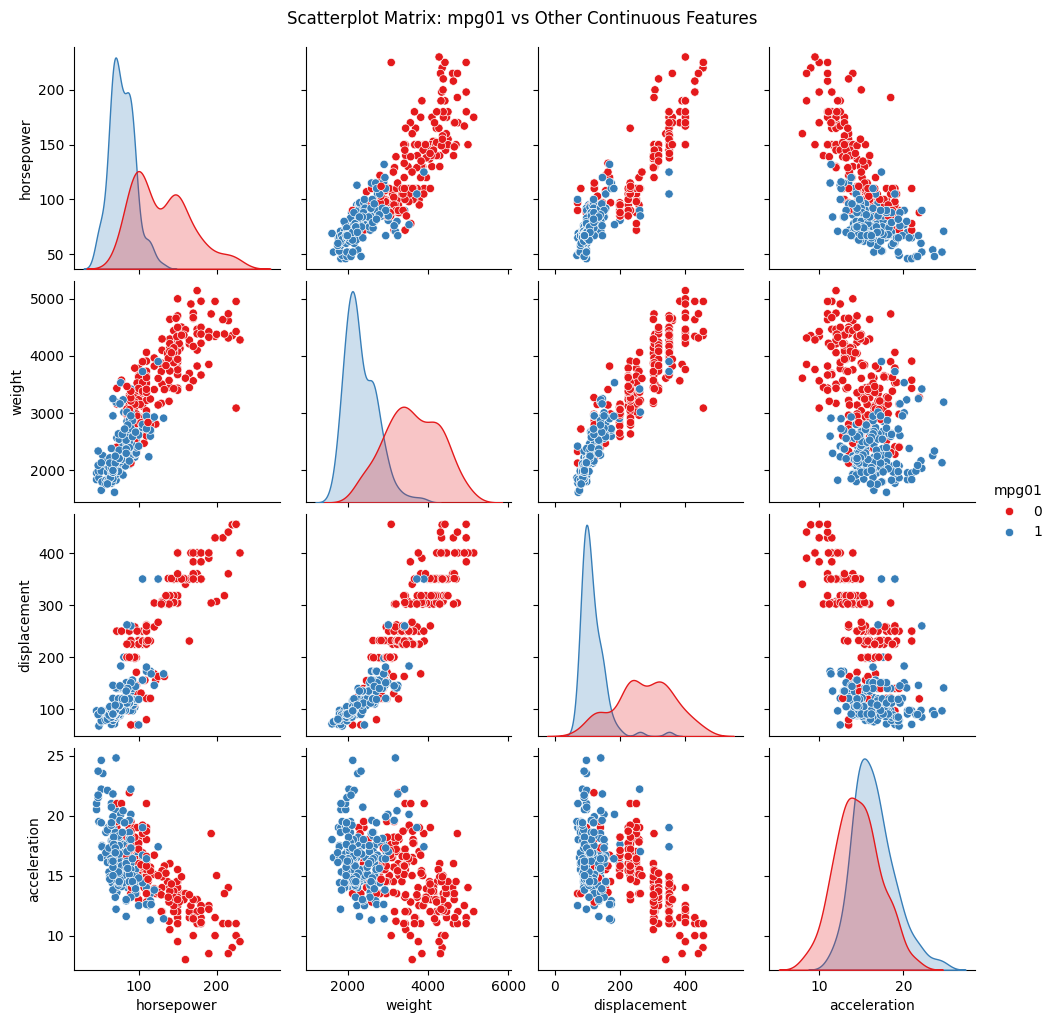

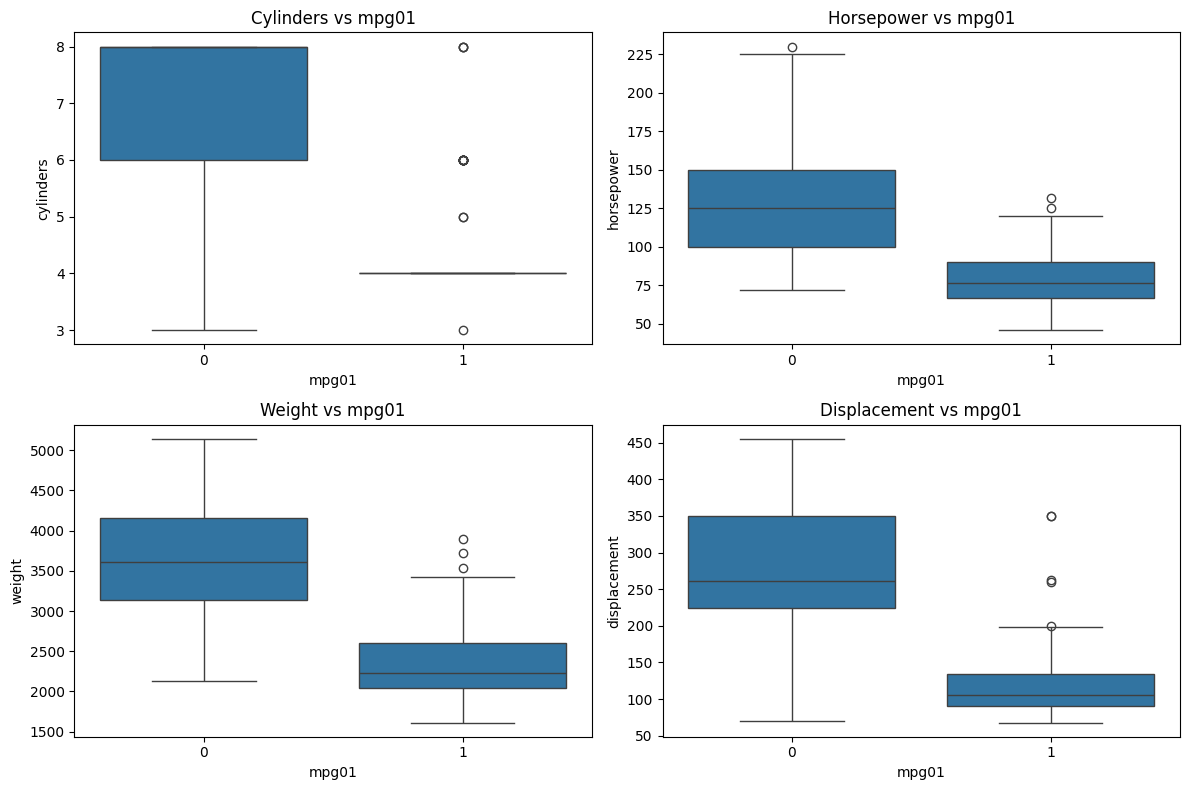

In [6]:
# Problem 1 (b)

%pip install seaborn
import matplotlib.pyplot as plt
import seaborn as sns

sns.pairplot(Auto, vars=["horsepower", "weight", "displacement", "acceleration"], 
             hue="mpg01", palette="Set1", diag_kind="kde")
plt.suptitle("Scatterplot Matrix: mpg01 vs Other Continuous Features", y=1.02)
plt.show()

plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
sns.boxplot(x="mpg01", y="cylinders", data=Auto)
plt.title("Cylinders vs mpg01")

plt.subplot(2,2,2)
sns.boxplot(x="mpg01", y="horsepower", data=Auto)
plt.title("Horsepower vs mpg01")

plt.subplot(2,2,3)
sns.boxplot(x="mpg01", y="weight", data=Auto)
plt.title("Weight vs mpg01")

plt.subplot(2,2,4)
sns.boxplot(x="mpg01", y="displacement", data=Auto)
plt.title("Displacement vs mpg01")

plt.tight_layout()
plt.show()


## Problem1 (b)

### scatterplot
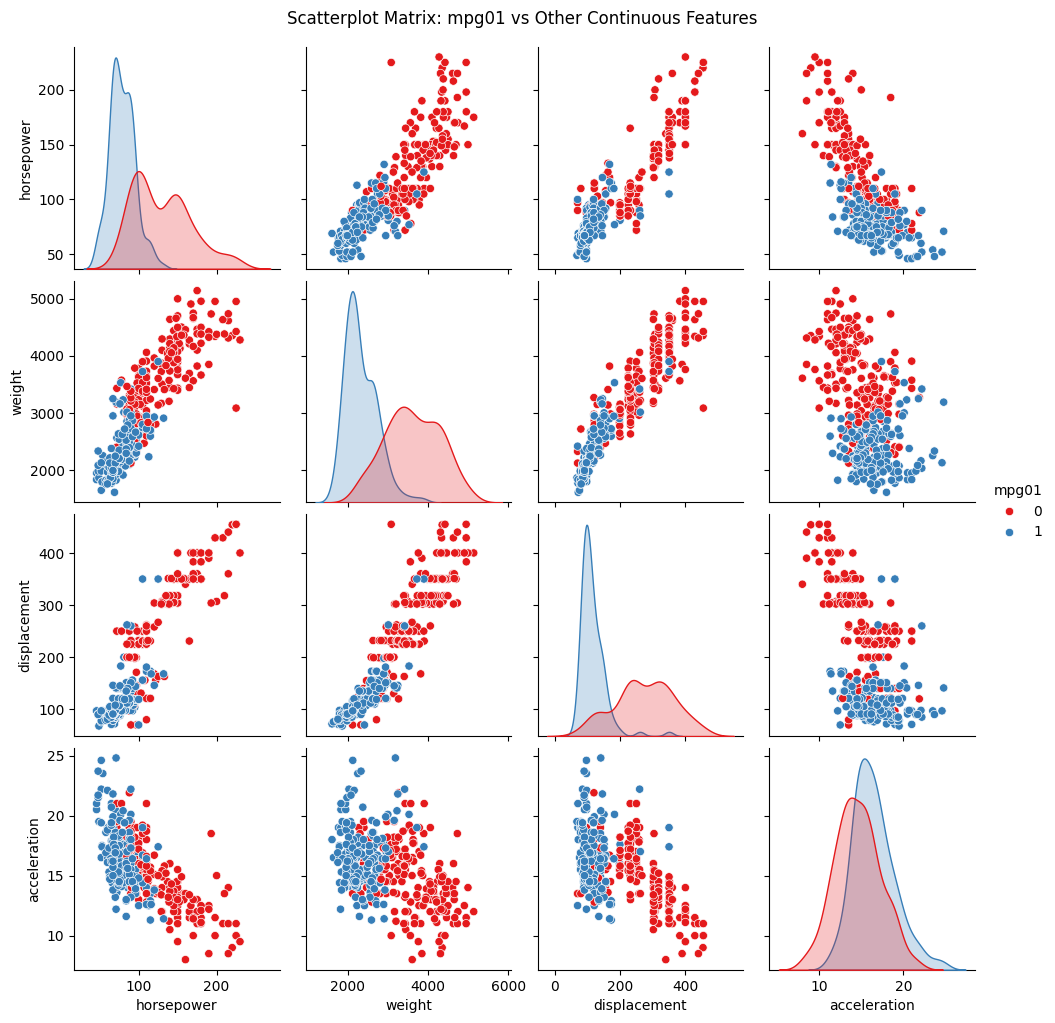
The selection of variables differs because scatterplots are best suited for continuous variables, allowing us to visualize how features like horsepower, weight, displacement, and acceleration vary with mpg01.


From the scatterplot matrix, we observe clear separation between high- and low-mileage cars for several variables.

Cars with lower horsepower, lighter weight, and smaller displacement tend to have higher mpg (mpg01 = 1).

Conversely, heavier cars with higher horsepower and larger displacement are associated with lower mpg (mpg01 = 0).

The variable acceleration does not show a strong separation.

Therefore, horsepower, weight, and displacement appear most useful in predicting mpg01.

### boxplots
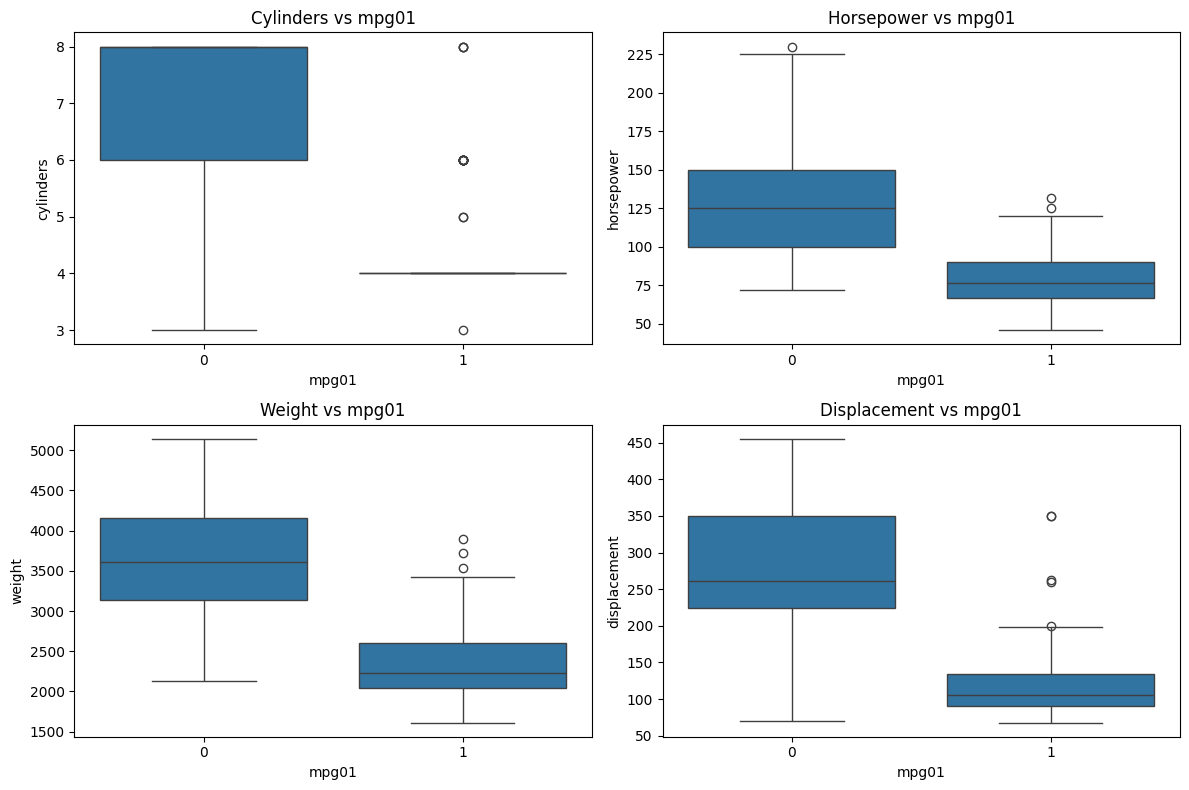
Boxplots are more appropriate when comparing distributions across categorical groups — in this case, the binary variable mpg01 — especially for features like cylinders (categorical by nature) and continuous features where we want to compare medians and spreads (e.g., horsepower, weight, displacement).


The boxplots show clear distinctions between high- and low-mileage cars.

Vehicles with more cylinders, higher horsepower, greater weight, and larger displacement tend to have lower mpg (mpg01 = 0).

In contrast, cars that are lighter, smaller, and less powerful (fewer cylinders, lower horsepower) typically achieve higher mpg (mpg01 = 1).

These findings suggest that cylinders, horsepower, weight, and displacement are the most useful predictors of mpg01.



In [7]:
# Problem 1 (c)
from sklearn.model_selection import train_test_split
X = Auto[["cylinders", "displacement", "horsepower", "weight", "acceleration"]]
y = Auto["mpg01"]

# Split into training and test sets (70% / 30%) with random_state=1
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1
)

print("Training size:", len(X_train))
print("Test size:", len(X_test))

Training size: 274
Test size: 118


In [ ]:
# Problem 1 (d) - LDA with the 4 variables most associated with mpg01
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

# Use the 3 predictors identified in (b)
X = Auto[["cylinders","horsepower", "weight", "displacement"]]
y = Auto["mpg01"]

# Split data (you can reuse the same split from part (c))
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1
)

# Train LDA model
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

# Predict and evaluate
y_pred = lda.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
error = 1 - accuracy

print(f"LDA Test Accuracy: {accuracy:.3f}")
print(f"LDA Test Error: {error:.3f}")


LDA Test Accuracy: 0.915
LDA Test Error: 0.085


## Problem 1 (d)

Based on the exploratory analysis in part (b), we selected cylinders, horsepower, weight, and displacement as the predictors for the LDA model.

Using the same training and test split from part (c), the model achieved a test accuracy of 91.5%, corresponding to a test error of 8.5%.

The accuracy is very similar to the model that included all five variables, suggesting that most of the predictive power comes from these four key features related to engine size and vehicle weight.

In [11]:
# Problem 1 (e) - QDA using 4 predictors: cylinders, horsepower, weight, displacement
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

X = Auto[["cylinders", "horsepower", "weight", "displacement"]]
y = Auto["mpg01"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1
)

qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)

y_pred = qda.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
error = 1 - accuracy

print(f"QDA Test Accuracy: {accuracy:.3f}")
print(f"QDA Test Error: {error:.3f}")


QDA Test Accuracy: 0.924
QDA Test Error: 0.076


## Problem 1 (e)

Using the same four predictors (cylinders, horsepower, weight, and displacement) identified in part (b), we fit a Quadratic Discriminant Analysis (QDA) model on the training data.

The QDA model achieved a test accuracy of 92.4% and a test error of 7.6%, slightly outperforming the LDA model (91.5% accuracy).

This improvement suggests that allowing a nonlinear decision boundary better captures the relationship between the predictors and fuel efficiency.

However, the performance gain is modest, indicating that the relationship is largely linear and that both LDA and QDA provide strong classification performance.

In [12]:
# Problem 1 (f) - Logistic Regression using 4 predictors
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X = Auto[["cylinders", "horsepower", "weight", "displacement"]]
y = Auto["mpg01"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1
)

log_reg = LogisticRegression(max_iter=1000)  
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
error = 1 - accuracy

print(f"Logistic Regression Test Accuracy: {accuracy:.3f}")
print(f"Logistic Regression Test Error: {error:.3f}")

Logistic Regression Test Accuracy: 0.915
Logistic Regression Test Error: 0.085


## Problem 1 (f)

Using the same four predictors — cylinders, horsepower, weight, and displacement — we fitted a logistic regression model to predict mpg01.

The model achieved a test accuracy of 91.5%, corresponding to a test error of 8.5%, which is almost identical to the performance of the LDA model.

This similarity arises because both logistic regression and LDA assume a linear decision boundary between the two classes.

Therefore, logistic regression provides comparable classification performance while relaxing some of LDA’s distributional assumptions.

In [14]:
# Problem 1 (g) - Naive Bayes using 4 predictors
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X = Auto[["cylinders", "horsepower", "weight", "displacement"]]
y = Auto["mpg01"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1
)

nb = GaussianNB()
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
error = 1 - accuracy

print(f"Naive Bayes Test Accuracy: {accuracy:.3f}")
print(f"Naive Bayes Test Error: {error:.3f}")

Naive Bayes Test Accuracy: 0.915
Naive Bayes Test Error: 0.085


## Problem 1 (g)

Using the same four predictors (cylinders, horsepower, weight, and displacement), the Naive Bayes classifier achieved a test accuracy of 91.5% and a test error of 8.5%, which is nearly identical to the LDA and logistic regression results.

This similarity occurs because the predictors are strongly and monotonically related to fuel efficiency, making the classification boundary almost linear.

Even though Naive Bayes assumes independence among predictors, this violation has little effect here since all variables influence mpg in the same direction.

In [15]:
# Problem 1 (h) - KNN using 4 predictors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X = Auto[["cylinders", "horsepower", "weight", "displacement"]]
y = Auto["mpg01"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1
)

# standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# try multiple K values
k_values = [1, 3, 5, 7, 9, 15, 25]
results = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    error = 1 - accuracy
    results.append((k, accuracy, error))
    print(f"K = {k:2d} | Test Accuracy = {accuracy:.3f} | Test Error = {error:.3f}")

K =  1 | Test Accuracy = 0.881 | Test Error = 0.119
K =  3 | Test Accuracy = 0.898 | Test Error = 0.102
K =  5 | Test Accuracy = 0.915 | Test Error = 0.085
K =  7 | Test Accuracy = 0.924 | Test Error = 0.076
K =  9 | Test Accuracy = 0.924 | Test Error = 0.076
K = 15 | Test Accuracy = 0.915 | Test Error = 0.085
K = 25 | Test Accuracy = 0.915 | Test Error = 0.085


## Problem 1 (h) KNN

Using the same four predictors (cylinders, horsepower, weight, and displacement), KNN was applied with several values of K.  

All predictors were standardized since KNN is sensitive to feature scale.

| K | Test Accuracy | Test Error |
|---|----------------|------------|
| 1 | 0.881 | 0.119 |
| 3 | 0.898 | 0.102 |
| 5 | 0.915 | 0.085 |
| 7 | 0.924 | 0.076 |
| 9 | 0.924 | 0.076 |
| 15 | 0.915 | 0.085 |
| 25 | 0.915 | 0.085 |

The lowest test error (7.6%) occurred at K = 7 and K = 9.  

As K increased beyond 10, performance plateaued, suggesting mild underfitting.  

Overall, K = 7 provided the best balance between bias and variance.


In [ ]:
# Problem 2 (a)
import numpy as np
rng = np.random.default_rng(1)
x = rng.normal(size=100)
y = x - 2 * x**2 + rng.normal(size=100)

## Problem 2 (a) Simulated Data

- **n = 100** (100 observations generated using `size=100`)  
- **p = 1** (one predictor, \(x\); note : (x^2) is a transformation of (x), not a separate variable)

### Data-generating model:

$$
x_i \sim \mathcal{N}(0,1), \quad
y_i = x_i - 2x_i^{2} + \varepsilon_i, \quad
\varepsilon_i \sim \mathcal{N}(0,1), \quad i = 1, \dots, 100
$$


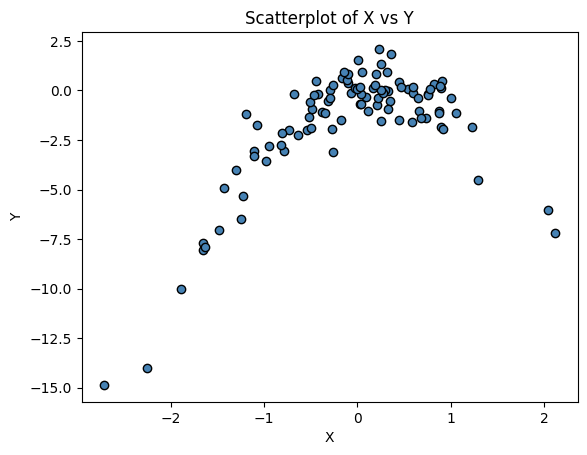

In [16]:
# Problem 2 (b)
import matplotlib.pyplot as plt
import numpy as np

# Simulated data
rng = np.random.default_rng(1)
x = rng.normal(size=100)
y = x - 2 * x**2 + rng.normal(size=100)

# Scatterplot
plt.scatter(x, y, color="steelblue", edgecolor="k")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Scatterplot of X vs Y")
plt.show()

## (b) Scatterplot of X vs Y

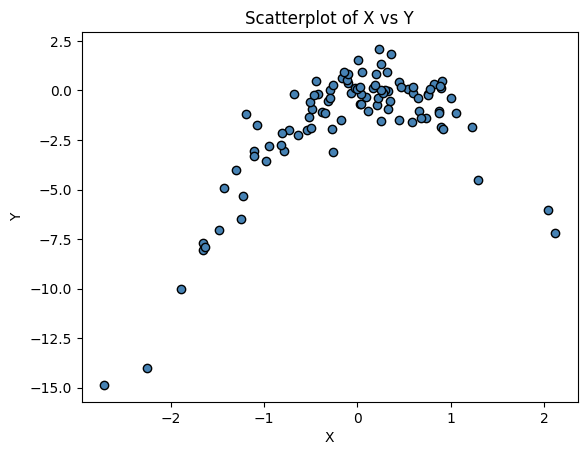

### Comment:

The scatterplot shows a **clear nonlinear relationship** between X and Y  

As X increases,Y first rises and then falls, forming an **inverted U-shaped pattern**.  

This curvature reflects the underlying quadratic term in the data-generating process:

$$
y = x - 2x^2 + \varepsilon
$$

The negative coefficient on x^2 causes Y to decrease when |X| becomes large.


In [ ]:
# Problem 2 (c)
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut, cross_val_score

rng = np.random.default_rng(1)
x = rng.normal(size=100)
y = x - 2 * x**2 + rng.normal(size=100)

data = pd.DataFrame({"x": x, "y": y})

loo = LeaveOneOut()

def loocv_mse(degree):
    # create polynomial features up to 'degree'
    X_poly = np.vander(x, N=degree+1, increasing=True)[:, 1:]  # exclude intercept column
    model = LinearRegression()
    # negative MSE (so take negative after mean)
    scores = cross_val_score(model, X_poly, y, cv=loo, scoring="neg_mean_squared_error")
    return -scores.mean()

degrees = [1, 2, 3, 4]
errors = [loocv_mse(d) for d in degrees]

results = pd.DataFrame({"Degree": degrees, "LOOCV MSE": errors})
print(results)

   Degree  LOOCV MSE
0       1   6.633030
1       2   1.122937
2       3   1.301797
3       4   1.332394


## Problem 2 (c)

We fit polynomial regression models of degree 1 to 4 using least squares and computed the Leave-One-Out Cross-Validation (LOOCV) mean squared error (MSE).

| Degree | LOOCV MSE |
|:-------:|:---------:|
| 1 | 6.633 |
| 2 | **1.123** |
| 3 | 1.302 |
| 4 | 1.332 |

### Comment:
The LOOCV error is smallest for the **quadratic model (degree = 2)**, indicating that a second-degree polynomial provides the best fit.

This is consistent with the true data-generating process  

$$
y = x - 2x^2 + \varepsilon,
$$

which is quadratic in x. Higher-degree models add unnecessary complexity and slightly increase the validation error.

### Why use LOOCV here

Although the true data-generating process is quadratic $$y = x - 2x^2 + \varepsilon$$
in practice we would not know this functional form.  

The purpose of LOOCV is to **mimic real-world model selection**,  
allowing us to compare models of different polynomial degrees and estimate their prediction errors.  

LOOCV correctly identifies the quadratic model (degree = 2) as the one with the lowest test error,  
showing that it best captures the underlying relationship without overfitting.


In [18]:
# Problem (d) - Repeat LOOCV with a different random seed
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut, cross_val_score

# new random seed
rng = np.random.default_rng(2)
x = rng.normal(size=100)
y = x - 2 * x**2 + rng.normal(size=100)

loo = LeaveOneOut()

def loocv_mse(degree):
    X_poly = np.vander(x, N=degree+1, increasing=True)[:, 1:]
    model = LinearRegression()
    scores = cross_val_score(model, X_poly, y, cv=loo, scoring="neg_mean_squared_error")
    return -scores.mean()

degrees = [1, 2, 3, 4]
errors_new = [loocv_mse(d) for d in degrees]

results_new = pd.DataFrame({"Degree": degrees, "LOOCV MSE": errors_new})
print(results_new)


   Degree  LOOCV MSE
0       1   7.560604
1       2   0.984037
2       3   0.968236
3       4   0.965959


## Problem 2 (d) LOOCV with a Different Random Seed

| Degree | LOOCV MSE |
|:-------:|:---------:|
| 1 | 7.561 |
| 2 | 0.984 |
| 3 | 0.968 |
| 4 | 0.966 |

### Comment:

The LOOCV errors differ slightly from part (c) because a different random seed  
generates new random noise in the simulated data.  

However, the overall pattern remains consistent — models of degree 2 to 4  
perform much better than the linear model (degree 1),  
and the **quadratic and cubic models** achieve the lowest errors.  

This shows that while random variation affects the exact MSE values,  
the cross-validation results are stable in identifying the correct (approximately quadratic) relationship.


## Problem 2 (e)

From part (c), the **quadratic model (degree = 2)** had the smallest LOOCV error (1.123).  
This result is exactly what we would expect, because the simulated data were generated from the model

$$
y = x - 2x^2 + \varepsilon,
$$

which is quadratic in \(x\).  

Therefore, the second-degree polynomial captures the true relationship most accurately,  
while higher-degree models introduce unnecessary complexity and slightly overfit the data.


In [19]:
# Problem2 (f)
import statsmodels.api as sm
import numpy as np

rng = np.random.default_rng(1)
x = rng.normal(size=100)
y = x - 2 * x**2 + rng.normal(size=100)

def fit_poly(degree):
    X_poly = np.vander(x, N=degree+1, increasing=True)
    model = sm.OLS(y, X_poly).fit()
    return model.summary()

for d in range(1, 5):
    print(f"\n=== Degree {d} Model ===")
    print(fit_poly(d))



=== Degree 1 Model ===
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                     45.60
Date:                Sat, 11 Oct 2025   Prob (F-statistic):           1.04e-09
Time:                        17:24:05   Log-Likelihood:                -230.83
No. Observations:                 100   AIC:                             465.7
Df Residuals:                      98   BIC:                             470.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4650      0

## Problem 2 (f) Significance of Coefficient Estimates

| Model | Significant Terms (p < 0.05) | R² | Comment |
|:------|:-----------------------------|:----:|:---------|
| **Degree 1** | Intercept, X | 0.318 | Linear model underfits; fails to capture curvature. |
| **Degree 2** | X, X² | 0.887 | Both terms highly significant; best fit to true quadratic pattern. |
| **Degree 3** | X, X² | 0.888 | X³ not significant (p = 0.287); unnecessary term. |
| **Degree 4** | X, X², X⁴ | 0.894 | Slightly higher R², but X³ not significant and LOOCV error increases → overfitting. |

### Comment:

Only the **quadratic model (degree = 2)** includes statistically significant predictors that correspond to the true data-generating process  

$$
y = x - 2x^2 + \varepsilon.
$$

Although the quartic model shows a marginally higher R^2, this improvement is due to overfitting noise rather than capturing genuine structure.

These findings are consistent with the LOOCV results, confirming that the quadratic model provides the best balance between fit and simplicity.



## Problem 3 (a) Smallest Training RSS

For a given number of predictors k:

- Best subset selection examines all possible combinations of k predictors and chooses the model with the lowest training RSS.
- Forward and backward stepwise selection are greedy methods that consider only a limited subset of possible models.

Therefore, the best subset model will always have the smallest (or equal-smallest) training RSS among the three approaches for the same k.


## Problem 3 (b) Smallest test RSS for a given k

There is no guarantee that any one approach (best subset, forward stepwise, backward stepwise) will always have the smallest test RSS for the same k.

- All three produce k-predictor models (same nominal complexity), but:
  - **Best subset** searches more models → **lower training RSS** but **higher selection variance**, so it can overfit the training noise and yield **higher test RSS**.
  - **Forward/backward stepwise** search fewer models → slightly more bias but **lower variance**, which can sometimes give **lower test RSS**.

**Conclusion:** The method with the smallest **test** RSS depends on the data (bias–variance trade-off). must compare them via a validation set or cross-validation; no approach is guaranteed to win for test error at a fixed k.


## Problem 3 (c)(i) 

**True.**  

In forward stepwise selection start with no predictors and add exactly one new predictor at each step without removing previously chosen ones.  

Therefore, the predictors in the k-variable model are a subset of those in the k+1-variable model selected by the same forward stepwise procedure.


## Problem 3 (c)(ii) 

**True.**  

In backward stepwise selection, start with all predictors and, at each step, remove exactly one predictor (and never add any back).  

Therefore, the set of predictors in the k-variable model is a subset of the predictors in the k+1 -variable model along the same backward stepwise path.

## Problem 3 (c)(iii) 

**False.**  

The k-variable model from backward stepwise and the k+1 -variable model from forward stepwise are produced by different search paths, so their predictor sets need not be nested.

*Why:* 

Forward adds variables greedily from an empty set; backward removes variables greedily from the full set. With correlated predictors, each procedure can choose different variables.

*Counterexample:*  

With predictors $X_1, X_2, X_3$:
- Forward for k+1=2 might select $X_1, X_2$.
- Backward for k=1 might retain only $X_3$.

Then $X_3$ is **not** a subset of $X_1, X_2$.


## Problem 3 (c)(iv) 

**False.**  

Forward and backward stepwise follow different search paths (add-one vs. drop-one). Their selected models at adjacent sizes are not guaranteed to be nested across procedures.

*Counterexample:*

With predictors $X_1, X_2, X_3$:
- Forward (k = 1) selects: X1  
- Backward (k+1 = 2) retains: {X2, X3}  

Then {X1} is **not** a subset of {X2, X3}.

## Problem 3 (c)(v) 

**False.**  

In best subset selection, the “best” k-variable model and the “best” k+1 -variable model are chosen independently to minimize training RSS at each size.  

Therefore, the predictors in the k-variable best model are not guaranteed to be contained in the k+1 -variable best model.

*Counterexample*  

Predictors: X1, X2, X3  

- Best k=1 model: {X1} (lowest 1-variable RSS)  
- Best k+1=2 model: {X2, X3} (together they beat {X1, X2} and {X1, X3})  

Then {X1} not nested {X2, X3}; models are **not nested** under best subset selection.

## Problem 4 (a)

### Correct choice: (iii)

Less flexible, and thus it will improve prediction accuracy when its increase in bias is less than its decrease in variance.

### Justification:

OLS is more flexible -> low bias, high variance (prone to overfitting).

Lasso adds an L1 penalty -> shrinks/zeros coefficients -> less flexible, raising bias but reducing variance.

If the variance reduction outweighs the bias increase, the test error decreases, yielding better prediction—exactly statement (iii).

## Problem 4 (b)

### Correct choice: (iii)

### Justification:

Ridge regression is less flexible than least squares because the L2 penalty shrinks coefficients toward zero, which increases bias but reduces variance. When the reduction in variance exceeds the increase in bias, the test error decreases and prediction accuracy improves—hence choice (iii). (Unlike lasso, ridge typically does not set coefficients exactly to zero.)

## Problem 4 (c)

### Correct choice: (ii)

### Justification:

Non-linear methods are more flexible than least squares, typically reducing bias but increasing variance. They improve prediction when the increase in variance is smaller than the decrease in bias, so the net test error drops—hence (ii).